In [18]:
from src.utils.myOptimization import solveGroupProblem, closed_form_group_alpha, AlphaFairnesstorch, \
    solveIndProblem, solve_closed_form
from src.utils.myPrediction import generate_random_features, customPredictionModel
from src.utils.plots import visLearningCurve
# ------------------------------------------------------------------
import numpy as np
import cvxpy as cp
import torch
import torch.nn as nn
import pandas as pd
from src.utils.features import get_all_features

from torch.utils.data import TensorDataset, DataLoader


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [19]:
df = pd.read_csv('E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\data\\data.csv')
df = df.sample(n=5000,random_state=42)

# Normalized cost to 0.1-10 range
cost = np.array(df['cost_t_capped'].values).reshape(-1, 1) * 10
cost = np.maximum(cost, 0.1)

# All features, standardized
features = df[get_all_features(df)].values
scaler = StandardScaler()
features = scaler.fit_transform(features)

# True benefit, predictor label normalzied to 1-100 range
true_benefit = np.array(df['benefit'].values).reshape(-1, 1) * 100
true_benefit = np.maximum(true_benefit, 1) 

# Group labels, 0 is White (Majority), 1 is Black
race = np.array(df['race'].values).reshape(-1, 1)

# Utils

## individual_fairness

In [20]:
def compute_individual_fairness(pred: torch.Tensor,
                                 true: torch.Tensor,
                                 race: torch.Tensor,
                                 d_func=None) -> torch.Tensor:
    """
    Computes individual fairness: similar individuals across groups should receive similar predictions.
    """
    # Flatten everything to 1D
    pred = pred.view(-1)
    true = true.view(-1)
    race = race.view(-1)

    if d_func is None:
        d_func = lambda y1, y2: torch.exp(-(y1 - y2).pow(2))

    mask0 = (race == 0)
    mask1 = (race == 1)

    pred0, pred1 = pred[mask0], pred[mask1]
    true0, true1 = true[mask0], true[mask1]

    n0, n1 = pred0.shape[0], pred1.shape[0]
    if n0 == 0 or n1 == 0:
        return torch.tensor(0.0, device=pred.device)

    pred_diff = pred0.unsqueeze(1) - pred1.unsqueeze(0)       # (n0, n1)
    true_sim = d_func(true0.unsqueeze(1), true1.unsqueeze(0)) # (n0, n1)

    fairness_penalty = (true_sim * pred_diff.pow(2)).mean()
    return fairness_penalty


In [21]:
def compute_statistical_parity(pred: torch.Tensor,
                              race: torch.Tensor) -> torch.Tensor:
    """
    Computes statistical parity: absolute difference in mean predictions between groups.
    """
    pred = pred.view(-1)
    race = race.view(-1)

    mask0 = (race == 0)
    mask1 = (race == 1)

    n0 = mask0.sum().item()
    n1 = mask1.sum().item()
    if n0 == 0 or n1 == 0:
        return torch.tensor(0.0, device=pred.device)

    mean0 = pred[mask0].mean()
    mean1 = pred[mask1].mean()
    stat_parity_penalty = torch.abs(mean0 - mean1)
    return stat_parity_penalty

## group_fairness

In [22]:
def compute_group_accuracy_parity(pred: torch.Tensor,
                                   true: torch.Tensor,
                                   race: torch.Tensor) -> torch.Tensor:
    """
    Computes group fairness as the absolute difference in MSE between two race groups.

    Args:
        pred: Predicted values, shape (n,)
        true: Ground truth values, shape (n,)
        race: Group membership labels (0 or 1), shape (n,)

    Returns:
        fairness_penalty: scalar tensor
    """
    pred = pred.view(-1)
    true = true.view(-1)
    race = race.view(-1)

    mask0 = (race == 0)
    mask1 = (race == 1)

    n0 = mask0.sum().item()
    n1 = mask1.sum().item()
    if n0 == 0 or n1 == 0:
        return torch.tensor(0.0, device=pred.device)

    mse0 = ((pred[mask0] - true[mask0]).pow(2)).mean()
    mse1 = ((pred[mask1] - true[mask1]).pow(2)).mean()
    f_acc = torch.abs(mse0 - mse1)

    return f_acc


## Atkinson's Index

In [23]:
def compute_atkinson_index(pred: torch.Tensor,
                           true: torch.Tensor,
                           beta: float = 0.5) -> torch.Tensor:
    """
    Computes the Atkinson index A on squared errors:
        e_i = (pred_i - true_i)^2  (clamped > 0)
        μ   = mean(e_i)
        U   = mean(e_i^(1-β))                  if β ≠ 1
              exp(mean(log(e_i)))             if β = 1
        A   = 1 – [U^(1/(1-β)) / μ]             if β ≠ 1
              1 – [exp(mean(log(e_i))) / μ]     if β = 1

    Args:
        pred: Predicted values, shape (n,)
        true:  Ground‐truth values, shape (n,)
        beta: Atkinson parameter (β ≥ 0)

    Returns:
        A: scalar Atkinson index in [0,1)
    """
    # flatten
    pred = pred.view(-1)
    true = true.view(-1)

    # squared errors, clamped to avoid zeros
    e = (pred - true).pow(2).clamp_min(1e-12)
    mu = e.mean()

    if abs(beta - 1.0) > 1e-8:
        U = e.pow(1.0 - beta).mean()
        term = U.pow(1.0 / (1.0 - beta))
    else:
        term = torch.exp(torch.log(e).mean())

    A = 1.0 - term / mu
    return A


# Opt Objective(AlphaFairness)

In [24]:
def alpha_fairness_group_utilities(benefit, allocation, group, alpha):
    """
    Compute group-wise alpha-fairness utilities.
    """
    groups = np.unique(group)
    utils = []
    for k in groups:
        mask = (group == k)
        Gk = float(mask.sum())
        # Compute average utility in group k
        util_k = (benefit[mask] * allocation[mask]).sum(axis=0).mean()  # mean total utility per individual in group
        if alpha == 1:
            val = np.log(util_k) if util_k > 0 else -np.inf
        elif alpha == 0:
            val = util_k
        elif alpha == float('inf'):
            # Min utility as min total utility)
            val = (benefit[mask] * allocation[mask]).sum(axis=0).min()
        else:
            val = util_k**(1 - alpha) / (1 - alpha)
        utils.append(val)
    return np.array(utils).sum()

## Prediction Model

In [25]:
class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1),
            nn.Softplus()
        )
            
    def forward(self, x):
        return self.model(x)

In [26]:

X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(true_benefit, dtype=torch.float32)
# Split the data, including cost and race
X_train, X_test, y_train, y_test, race_train, race_test, cost_train, cost_test = train_test_split(
    X_tensor, y_tensor, race, torch.tensor(cost, dtype=torch.float32), test_size=0.5, random_state=42
)


## Training Function

In [27]:
# ------------------------------------------------------------------
#  Fairness helpers
# ------------------------------------------------------------------
# compute_individual_fairness(pred, true, race)
# compute_group_accuracy_parity(pred, true, race)
# solveGroupProblem(benefit, cost, race, alpha, Q)
# alpha_fairness_group_utilities(benefit, d, race, alpha)

# ------------------------------------------------------------------
#  TRAIN + EVALUATE FUNCTION
# ------------------------------------------------------------------
def train_fair_model_logged(
        X_train, y_train, race_train,
        X_test,  y_test,  race_test,
        cost_test,
        model_class, input_dim,
        alpha, Q,
        lambda_fair=0.0, fairness_type="none",
        num_epochs=30, lr=1e-2, batch_size=None,
        dropout_rate=0.1, weight_decay=1e-4,
        device=torch.device("cpu")):
    """
    Train a fairness–aware predictor and log train-loss, test-MSE,
    test-normalised-regret, and test-fairness each epoch.
    """
    # -------------------------- type-check -----------------------------
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32)
        X_test  = torch.tensor(X_test, dtype=torch.float32)
    if not isinstance(y_train, torch.Tensor):
        y_train = torch.tensor(y_train, dtype=torch.float32)
        y_test  = torch.tensor(y_test, dtype=torch.float32)
    if not isinstance(race_train, torch.Tensor):
        race_train = torch.tensor(race_train, dtype=torch.float32)
        race_test  = torch.tensor(race_test, dtype=torch.float32)
    # -------------------------- dataloaders ------------------------
    train_ds = TensorDataset(X_train.to(device), y_train.to(device), race_train.to(device))
    if batch_size is None:
        batch_size = len(train_ds)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # -------------------------- model & opt ------------------------
    model  = model_class(input_dim, dropout_rate=dropout_rate).to(device)
    optim  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit   = nn.MSELoss()

    # -------------------------- logs -------------------------------
    loss_log, mse_log, regret_log, fairness_log = [], [], [], []

    # -------------------------- training loop ----------------------
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for x_b, y_b, r_b in train_loader:
            pred_b = model(x_b).squeeze()
            mse    = crit(pred_b, y_b)

            # fairness penalty
            if fairness_type == "individual":
                fair_pen = compute_individual_fairness(pred_b, y_b, r_b)
            elif fairness_type == "acc_parity":
                fair_pen = compute_group_accuracy_parity(pred_b, y_b, r_b)
            elif fairness_type == "stat_parity":
                fair_pen = compute_statistical_parity(pred_b, r_b)
            elif fairness_type == "atkinson":
                fair_pen = compute_atkinson_index(pred_b, y_b)
            else:
                fair_pen = torch.tensor(0.0, device=device)

            loss = mse + lambda_fair * fair_pen
            optim.zero_grad(); loss.backward(); optim.step()
            epoch_loss += loss.item() * x_b.size(0)

        loss_log.append(epoch_loss / len(train_ds))

        # ----------------- evaluation on the held-out set ----------
        model.eval()
        with torch.no_grad():
            pred_test = model(X_test.to(device)).squeeze().cpu()
        mse_val = ((pred_test - y_test).pow(2)).mean().item()
        mse_log.append(mse_val)

        # ensure positivity for optimisation step
        pred_b_np  = pred_test.numpy().reshape(-1, 1)
        pred_b_np  = np.maximum(pred_b_np, 1e-1)

        # regret on test set
        race_np    = race_test.numpy()
        if fairness_type == "acc_parity":

            sol_pred, _,_,_ = closed_form_group_alpha(pred_b_np, cost_test, race_np, alpha=alpha, Q=Q)
            sol_true, _,_,_ = closed_form_group_alpha(y_test, cost_test, race_np, alpha=alpha, Q=Q)
            true_obj    = alpha_fairness_group_utilities(y_test, sol_true, race_np, alpha=alpha)
            pred_obj    = alpha_fairness_group_utilities(y_test, sol_pred, race_np, alpha=alpha)
        
        else:
            b_pred = pred_b_np.flatten()
            b_true = y_test.flatten()
            c_vec = cost_test.flatten()
            ones_array = np.ones_like(b_pred)

            # solve the individual problem
            sol_pred_i, _ = solve_closed_form(ones_array ,b_pred, c_vec, alpha=alpha, Q=Q)
            sol_true_i, _ = solve_closed_form(ones_array,b_true, c_vec, alpha=alpha, Q=Q)

            # build torch‐tensors of utils = benefit * decision
            util_true = torch.tensor(b_true * sol_true_i, dtype=torch.float32, device=device)
            util_pred = torch.tensor(b_true * sol_pred_i, dtype=torch.float32, device=device)

            true_obj = AlphaFairnesstorch(util_true, alpha).item()
            pred_obj = AlphaFairnesstorch(util_pred, alpha).item()
        norm_regret = (true_obj - pred_obj) / (abs(true_obj) + 1e-7)
        regret_log.append(norm_regret)

        # fairness on test set
        if fairness_type == "individual":
            fair_val = compute_individual_fairness(pred_test, y_test, race_test).item()
        elif fairness_type == "acc_parity":
            fair_val = compute_group_accuracy_parity(pred_test, y_test, race_test).item()
        elif fairness_type == "stat_parity":
            fair_val = compute_statistical_parity(pred_test, race_test).item()
        elif fairness_type == "atkinson":
            fair_val = compute_atkinson_index(pred_test, y_test).item()
        else:
            fair_val = None
        fairness_log.append(fair_val)

        # ----------- progress print every 5 epochs -----------------
        if epoch == 1 or epoch % 10 == 0:
            msg = (f"Epoch {epoch:02d}/{num_epochs} | "
                   f"Train-Loss {loss_log[-1]:.4f} | "
                   f"Test-MSE {mse_val:.4f} | Regret {norm_regret:.4f}")
            if fair_val is not None:
                msg += f" | Fair {fair_val:.4f}"
            print(msg)

    # ---------------------- tidy fairness log ---------------------
    if fairness_type == "none":
        fairness_log = None  # keep your plotting function happy

    return model, {"loss_log": loss_log,
                   "mse_log": mse_log,
                   "regret_log": regret_log,
                   "fairness_log": fairness_log}


## Define Alpha & Q

In [28]:
# Save to json
import json
params = {
    "n_sample": 5000 ,
    "alpha": 1.5,
    "Q": 2500,
    "epochs": 100,
    "lambdas": 1.0,
    "lr": 0.01
}

with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_twoStage.json", "w") as f:
    json.dump(params, f, indent=4)

import json

with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_twoStage.json", "r") as f:
    params = json.load(f)

n_sample = params["n_sample"]
alpha   = params["alpha"]
Q       = params["Q"]
epochs  = params["epochs"]
lambdas = params["lambdas"]
lr      = params["lr"]


# Training Group (Pred+Opt)

Epoch 01/100 | Train-Loss 590.3440 | Test-MSE 332.3400 | Regret 2.4209 | Fair 135.5624
Epoch 10/100 | Train-Loss 375.6591 | Test-MSE 310.5591 | Regret 1.1248 | Fair 30.3884
Epoch 20/100 | Train-Loss 298.8288 | Test-MSE 243.1246 | Regret 1.1376 | Fair 40.3658
Epoch 30/100 | Train-Loss 269.4948 | Test-MSE 246.0836 | Regret 2.5632 | Fair 40.5040
Epoch 40/100 | Train-Loss 263.7969 | Test-MSE 233.2836 | Regret 2.5635 | Fair 45.5752
Epoch 50/100 | Train-Loss 261.1350 | Test-MSE 232.7826 | Regret 2.5633 | Fair 40.2126
Epoch 60/100 | Train-Loss 268.7650 | Test-MSE 231.9754 | Regret 2.5625 | Fair 41.0427
Epoch 70/100 | Train-Loss 258.8460 | Test-MSE 231.9257 | Regret 2.5625 | Fair 38.5616
Epoch 80/100 | Train-Loss 262.6401 | Test-MSE 230.5199 | Regret 2.5626 | Fair 42.9709
Epoch 90/100 | Train-Loss 257.9939 | Test-MSE 230.7717 | Regret 2.5625 | Fair 39.9760
Epoch 100/100 | Train-Loss 265.2646 | Test-MSE 229.8284 | Regret 2.5625 | Fair 42.0823


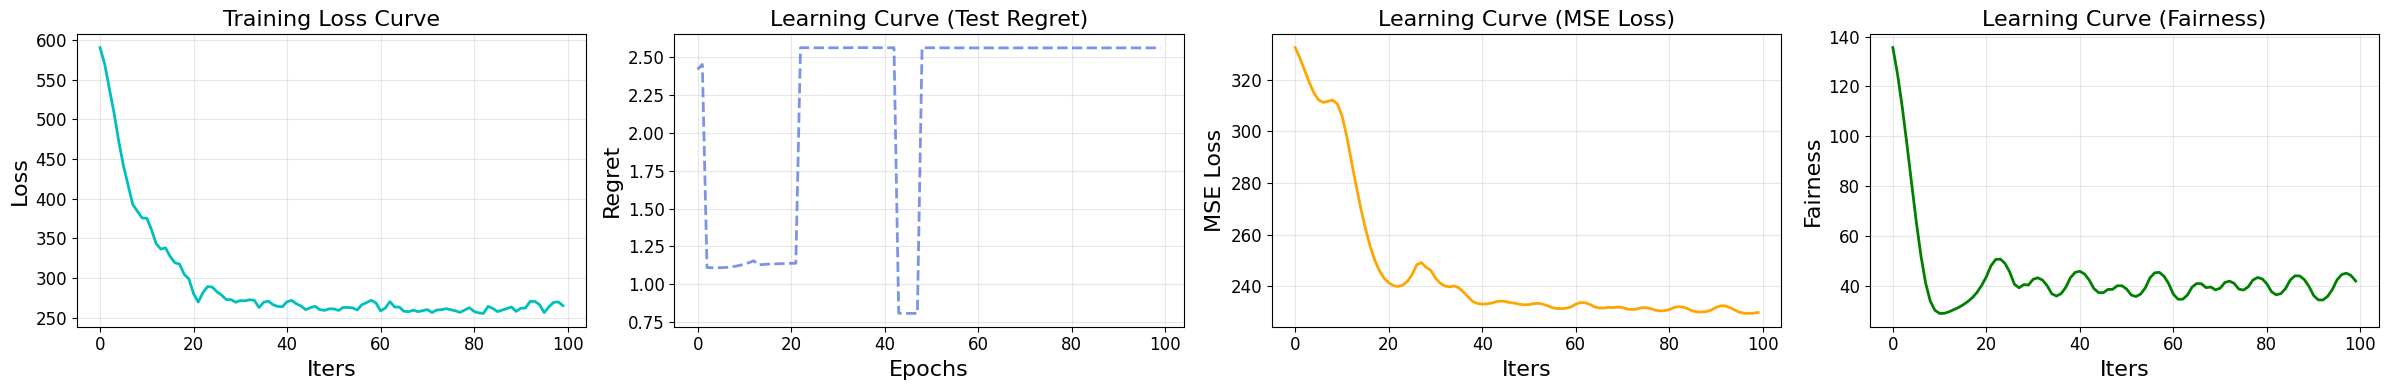

In [29]:
model, logs = train_fair_model_logged(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, Q=Q,
    lambda_fair=lambdas,
    fairness_type="acc_parity", 
    num_epochs=epochs, lr=lr
)

# -----------------------------------------------------------------
#  Visualise learning curves
# -----------------------------------------------------------------
visLearningCurve(logs["loss_log"],
                 logs["regret_log"],
                 logs["mse_log"],
                 logs["fairness_log"])


# Training Individual

Epoch 01/100 | Train-Loss 380.8028 | Test-MSE 332.5967 | Regret 0.0804 | Fair 0.0001
Epoch 10/100 | Train-Loss 294.6546 | Test-MSE 252.8270 | Regret 0.0850 | Fair 0.4048
Epoch 20/100 | Train-Loss 270.0251 | Test-MSE 245.1337 | Regret 0.1045 | Fair 1.0409
Epoch 30/100 | Train-Loss 257.1794 | Test-MSE 231.7302 | Regret 0.0825 | Fair 0.2188
Epoch 40/100 | Train-Loss 253.3925 | Test-MSE 231.4043 | Regret 0.0840 | Fair 0.2721
Epoch 50/100 | Train-Loss 251.8223 | Test-MSE 228.5218 | Regret 0.0836 | Fair 0.1895
Epoch 60/100 | Train-Loss 251.2263 | Test-MSE 228.7534 | Regret 0.0816 | Fair 0.0778
Epoch 70/100 | Train-Loss 250.5967 | Test-MSE 227.9188 | Regret 0.0816 | Fair 0.0792
Epoch 80/100 | Train-Loss 250.2597 | Test-MSE 227.8777 | Regret 0.0819 | Fair 0.0727
Epoch 90/100 | Train-Loss 250.1338 | Test-MSE 227.8283 | Regret 0.0816 | Fair 0.0176
Epoch 100/100 | Train-Loss 250.0856 | Test-MSE 227.6617 | Regret 0.0814 | Fair 0.0225


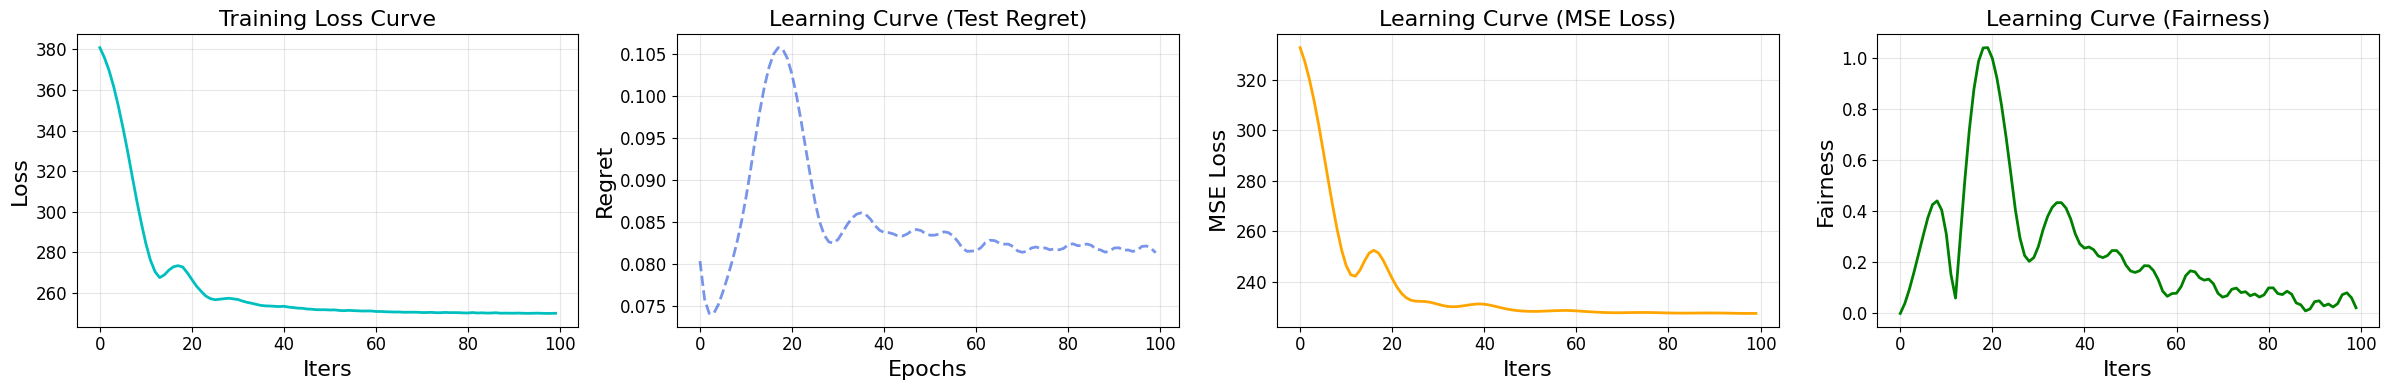

In [30]:


model, logs = train_fair_model_logged(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, Q=Q,
    lambda_fair=lambdas,
    fairness_type="stat_parity", 
    num_epochs=epochs, lr=lr
)

# -----------------------------------------------------------------
#  Visualise learning curves
# -----------------------------------------------------------------
visLearningCurve(logs["loss_log"],
                 logs["regret_log"],
                 logs["mse_log"],
                 logs["fairness_log"])


Epoch 01/100 | Train-Loss 380.7238 | Test-MSE 332.7686 | Regret 0.0762 | Fair 0.0054
Epoch 10/100 | Train-Loss 300.0952 | Test-MSE 257.0640 | Regret 0.0810 | Fair 1.8085
Epoch 20/100 | Train-Loss 271.3434 | Test-MSE 243.9094 | Regret 0.1042 | Fair 4.1923
Epoch 30/100 | Train-Loss 257.8571 | Test-MSE 231.8090 | Regret 0.0798 | Fair 0.9989
Epoch 40/100 | Train-Loss 253.6551 | Test-MSE 230.8351 | Regret 0.0857 | Fair 1.0689
Epoch 50/100 | Train-Loss 251.8063 | Test-MSE 228.3986 | Regret 0.0831 | Fair 0.5094
Epoch 60/100 | Train-Loss 251.2020 | Test-MSE 228.4433 | Regret 0.0822 | Fair 0.3657
Epoch 70/100 | Train-Loss 250.5724 | Test-MSE 227.7601 | Regret 0.0815 | Fair 0.2534
Epoch 80/100 | Train-Loss 250.3360 | Test-MSE 227.8652 | Regret 0.0826 | Fair 0.2289
Epoch 90/100 | Train-Loss 250.2961 | Test-MSE 227.6358 | Regret 0.0822 | Fair 0.1947
Epoch 100/100 | Train-Loss 250.1950 | Test-MSE 227.6183 | Regret 0.0821 | Fair 0.1733


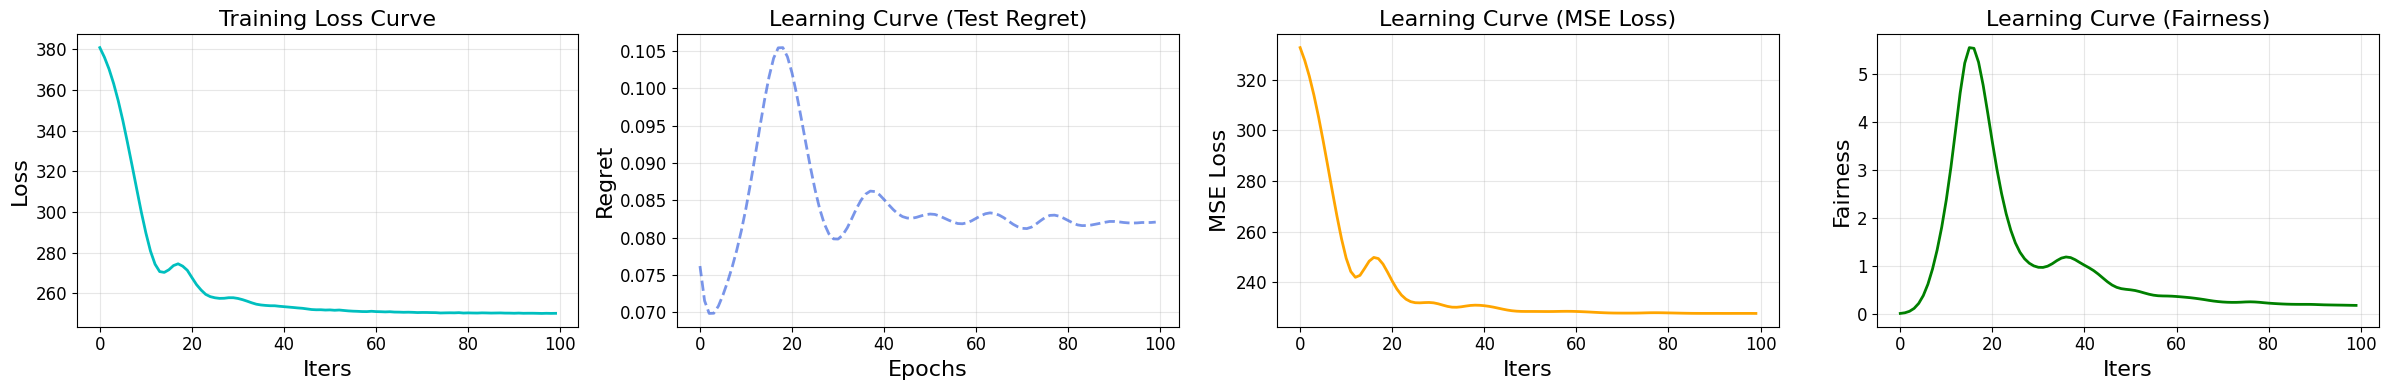

In [31]:

model, logs = train_fair_model_logged(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, Q=Q,
    lambda_fair=lambdas,
    fairness_type="individual", 
    num_epochs=epochs, lr=lr
)

# -----------------------------------------------------------------
#  Visualise learning curves
# -----------------------------------------------------------------
visLearningCurve(logs["loss_log"],
                 logs["regret_log"],
                 logs["mse_log"],
                 logs["fairness_log"])


# Evaluation

In [32]:
# ------------------------------------------------------------------
#  MULTIPLE-TRIAL TRAINER
# ------------------------------------------------------------------
def train_many_trials(
        X_train, y_train, race_train,
        X_test,  y_test,  race_test,
        cost_test,
        model_class, input_dim,
        alpha, Q,
        lambda_fair=0.0, fairness_type="none",
        num_epochs=30, lr=1e-2, batch_size=None,
        n_trials=10, base_seed=2025,
        dropout_rate=0.1, weight_decay=1e-4,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Run `train_fair_model_logged` for `n_trials` independent seeds and
    return epoch-wise averages of loss, MSE, regret, and fairness.
    """

    # storage: list of dicts, one per trial
    trials_logs = []

    for t in range(n_trials):
        seed = base_seed + t
        torch.manual_seed(seed)
        np.random.seed(seed)

        _, logs = train_fair_model_logged(
            X_train, y_train, race_train,
            X_test,  y_test,  race_test,
            cost_test,
            model_class, input_dim,
            alpha, Q,
            lambda_fair=lambda_fair, # type: ignore
            fairness_type=fairness_type,
            num_epochs=num_epochs,
            lr=lr,
            batch_size=batch_size,
            dropout_rate=dropout_rate,
            weight_decay=weight_decay,
            device=device
        )
        trials_logs.append(logs)

    # ---------- epoch-wise aggregation (mean) ----------------------
    keys = ["loss_log", "mse_log", "regret_log", "fairness_log"]
    avg_logs = {}
    for k in keys:
        # some runs may have fairness_log = None when fairness_type="none"
        if trials_logs[0][k] is None:
            avg_logs[k] = None
            continue
        stack = np.vstack([trial[k] for trial in trials_logs])   # shape: (n_trials, num_epochs)
        avg_logs[k] = stack.mean(axis=0).tolist()                # convert back to list for plotting
        std_k = stack.std(axis=0)[-1]                            # std at final epoch
        mean_k = avg_logs[k][-1]
        print(f"[{k.replace('_log','').upper()}]  final-epoch mean = {mean_k:.4f}  |  std = {std_k:.4f}")

    return avg_logs


Epoch 01/100 | Train-Loss 593.3285 | Test-MSE 333.5727 | Regret 0.6090 | Fair 138.6810
Epoch 10/100 | Train-Loss 372.5160 | Test-MSE 308.8752 | Regret 1.1265 | Fair 30.8386
Epoch 20/100 | Train-Loss 303.3567 | Test-MSE 249.6691 | Regret 0.8050 | Fair 41.1014
Epoch 30/100 | Train-Loss 287.4521 | Test-MSE 246.8519 | Regret 0.8131 | Fair 37.2828
Epoch 40/100 | Train-Loss 271.5817 | Test-MSE 236.5656 | Regret 0.8093 | Fair 33.4529
Epoch 50/100 | Train-Loss 260.5565 | Test-MSE 233.2328 | Regret 0.8070 | Fair 37.6318
Epoch 60/100 | Train-Loss 262.3670 | Test-MSE 233.3301 | Regret 2.5633 | Fair 35.0422
Epoch 70/100 | Train-Loss 259.7468 | Test-MSE 231.3462 | Regret 2.5627 | Fair 40.2677
Epoch 80/100 | Train-Loss 255.4983 | Test-MSE 231.7674 | Regret 2.5630 | Fair 37.4166
Epoch 90/100 | Train-Loss 259.9560 | Test-MSE 230.6441 | Regret 2.5629 | Fair 40.4465
Epoch 100/100 | Train-Loss 254.8720 | Test-MSE 229.8618 | Regret 2.5632 | Fair 42.2812
Epoch 01/100 | Train-Loss 593.7266 | Test-MSE 333.72

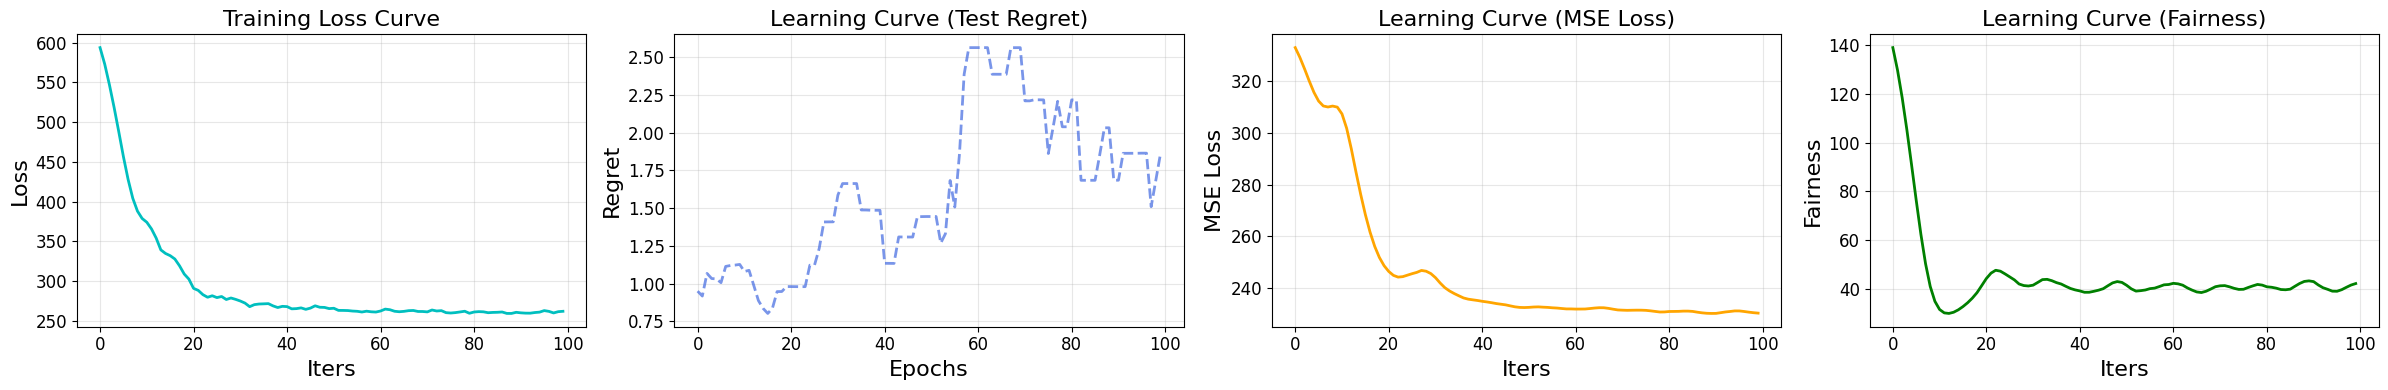

In [33]:
avg_logs = train_many_trials(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, Q=Q,
    lambda_fair=lambdas,
    fairness_type="acc_parity",
    num_epochs=epochs,
    lr=lr,
    n_trials=10
)

# Visualise the averaged learning curves
visLearningCurve(avg_logs["loss_log"],
                 avg_logs["regret_log"],
                 avg_logs["mse_log"],
                 avg_logs["fairness_log"])


Epoch 01/100 | Train-Loss 380.4744 | Test-MSE 332.3922 | Regret 0.0738 | Fair 0.0042
Epoch 10/100 | Train-Loss 295.0660 | Test-MSE 252.0080 | Regret 0.0807 | Fair 2.0884
Epoch 20/100 | Train-Loss 265.5639 | Test-MSE 240.0206 | Regret 0.0921 | Fair 3.5508
Epoch 30/100 | Train-Loss 255.8153 | Test-MSE 230.6217 | Regret 0.0827 | Fair 1.0600
Epoch 40/100 | Train-Loss 252.9308 | Test-MSE 229.8759 | Regret 0.0841 | Fair 0.8751
Epoch 50/100 | Train-Loss 251.7368 | Test-MSE 228.8056 | Regret 0.0842 | Fair 0.5674
Epoch 60/100 | Train-Loss 251.0887 | Test-MSE 228.1973 | Regret 0.0822 | Fair 0.3875
Epoch 70/100 | Train-Loss 250.6825 | Test-MSE 228.1943 | Regret 0.0819 | Fair 0.2921
Epoch 80/100 | Train-Loss 250.3650 | Test-MSE 227.8903 | Regret 0.0820 | Fair 0.2317
Epoch 90/100 | Train-Loss 250.2674 | Test-MSE 227.7362 | Regret 0.0817 | Fair 0.2040
Epoch 100/100 | Train-Loss 250.1434 | Test-MSE 227.6271 | Regret 0.0820 | Fair 0.1736
Epoch 01/100 | Train-Loss 380.6379 | Test-MSE 332.6697 | Regret 

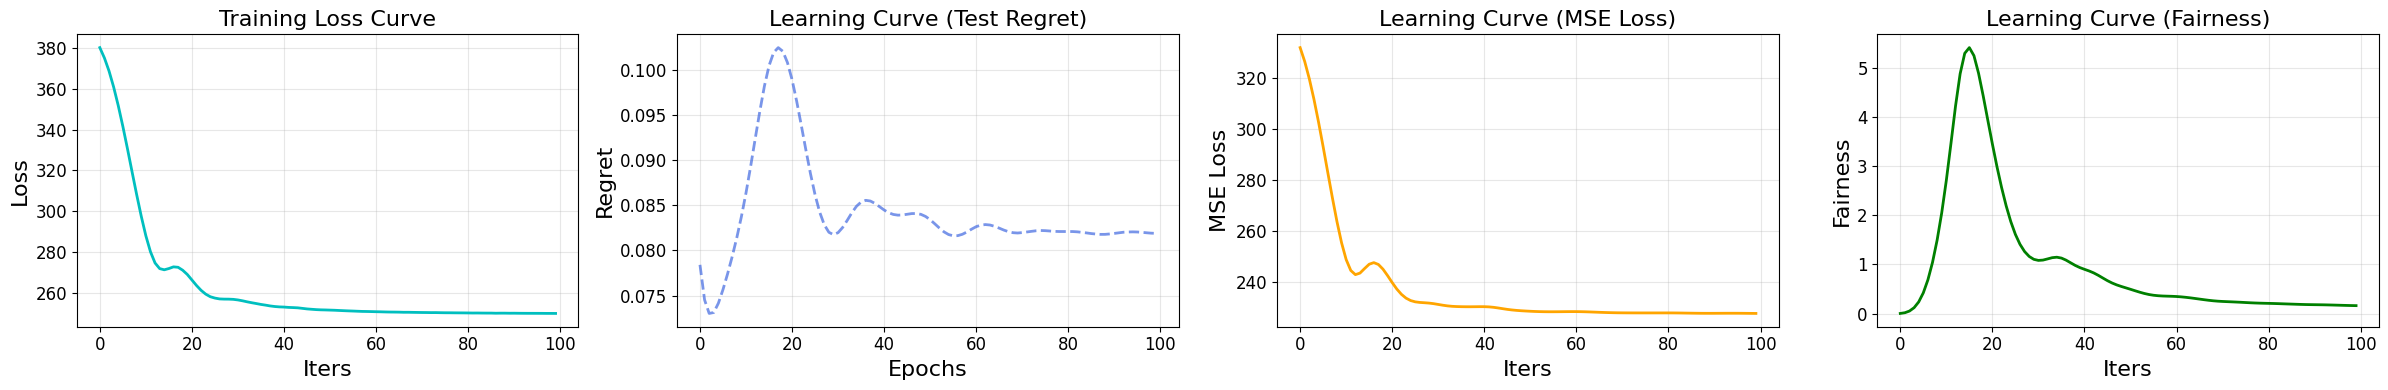

In [34]:
avg_logs = train_many_trials(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, Q=Q,
    lambda_fair=lambdas,
    fairness_type="individual",
    num_epochs=epochs,
    lr=lr,
    n_trials=10
)

# Visualise the averaged learning curves
visLearningCurve(avg_logs["loss_log"],
                 avg_logs["regret_log"],
                 avg_logs["mse_log"],
                 avg_logs["fairness_log"])


Epoch 01/100 | Train-Loss 380.4891 | Test-MSE 332.4348 | Regret 0.0752 | Fair 0.0230
Epoch 10/100 | Train-Loss 292.9766 | Test-MSE 251.1527 | Regret 0.0843 | Fair 0.3862
Epoch 20/100 | Train-Loss 265.2143 | Test-MSE 241.0608 | Regret 0.0902 | Fair 0.5906
Epoch 30/100 | Train-Loss 255.1378 | Test-MSE 230.4420 | Regret 0.0839 | Fair 0.3282
Epoch 40/100 | Train-Loss 252.7920 | Test-MSE 230.0956 | Regret 0.0852 | Fair 0.1986
Epoch 50/100 | Train-Loss 251.6790 | Test-MSE 228.9985 | Regret 0.0835 | Fair 0.1794
Epoch 60/100 | Train-Loss 251.1972 | Test-MSE 228.2517 | Regret 0.0827 | Fair 0.1625
Epoch 70/100 | Train-Loss 250.8176 | Test-MSE 228.3282 | Regret 0.0828 | Fair 0.1526
Epoch 80/100 | Train-Loss 250.3442 | Test-MSE 227.8058 | Regret 0.0827 | Fair 0.0925
Epoch 90/100 | Train-Loss 250.4130 | Test-MSE 227.8728 | Regret 0.0821 | Fair 0.1072
Epoch 100/100 | Train-Loss 250.1371 | Test-MSE 227.5781 | Regret 0.0823 | Fair 0.0754
Epoch 01/100 | Train-Loss 380.6476 | Test-MSE 332.6819 | Regret 

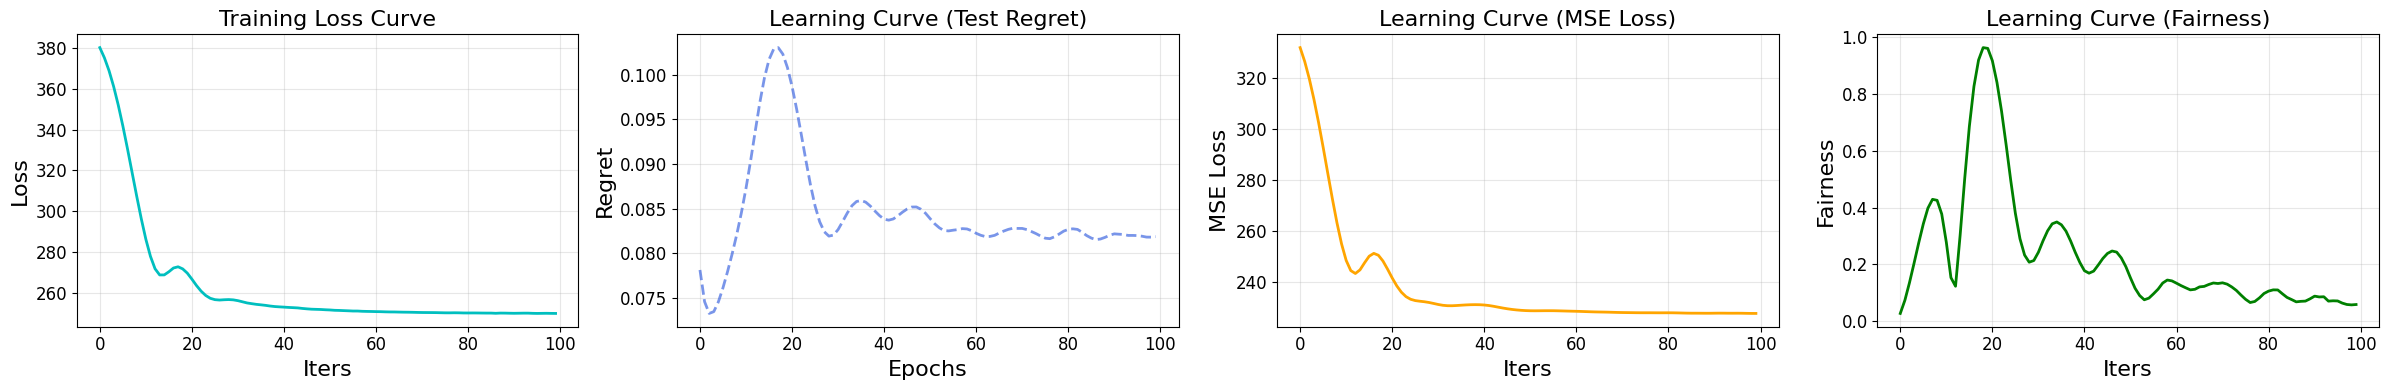

In [35]:
avg_logs = train_many_trials(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, Q=Q,
    lambda_fair=lambdas,
    fairness_type="stat_parity",
    num_epochs=epochs,
    lr=lr,
    n_trials=10
)

# Visualise the averaged learning curves
visLearningCurve(avg_logs["loss_log"],
                 avg_logs["regret_log"],
                 avg_logs["mse_log"],
                 avg_logs["fairness_log"])
